In [49]:
library(tidyverse)
library(patchwork)
source("gene_track_plots.R")
source("helpers.R")


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [3]:
transcripts <- read_tsv("example_data/transcripts.tsv")
protein_domains <- read_tsv("example_data/domains.tsv") %>%
    select(-c(blockCount, score))


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  ensembl_version = col_double(),
  chrom = col_double(),
  feature_start = col_double(),
  feature_end = col_double(),
  frame = col_double(),
  gene_version = col_double(),
  transcript_version = col_double(),
  transcript_support_level = col_double(),
  exon_version = col_double(),
  exon_number = col_double(),
  protein_id = col_logical(),
  protein_version = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────
cols(
  chrom = col_double(),
  strand = col_character(),
  name = col_character(),
  score = col_double(),
  blockCount = col_double(),
  feature_unique_identifier = col_character(),
  start = col_double(),
  end = col_double(),
  sub_track = col_character(),
  jstart = col_double(),
  jend = col_double()
)




In [23]:
protein_domains %>%
    # Each row is a genomic region coding for a "domain" with a given name

    # To distinguish two distinct domains coming from different regions of the genome
    # (or different regions of the same protein), use feature_unique_identifier
    # for e.g., here are two RNA binding domains, RRM_1, with the same name
    # to distinguish them, use the feature_unique_identifier column (1343_RRM_1 vs 1344_RRM_1)
    
    # The jstart and jend indicate that there is an exon-exon
    # splice junction connecting two genomic regions. For example, 1344_RRM_1 is encoded
    # by two exons, spliced together by the 35190995-35191340 junction

    # 1343_RRM_1 is encoded within one exon, so there is splice junction

    # note that these coordinates are 1-based (they come from UCSC)
    head(6)

chrom,strand,name,feature_unique_identifier,start,end,sub_track,jstart,jend
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,-,NOPS,1342_NOPS,35189312,35189382,ucsc_pfam_domains,35189382,35190497
1,-,NOPS,1342_NOPS,35190497,35190583,ucsc_pfam_domains,NA,NA
1,-,RRM_1,1343_RRM_1,35190713,35190893,ucsc_pfam_domains,NA,NA
1,-,RRM_1,1344_RRM_1,35190923,35190995,ucsc_pfam_domains,35190995,35191340
1,-,RRM_1,1344_RRM_1,35191340,35191463,ucsc_pfam_domains,NA,NA
1,+,zf-FCS,1345_zf-FCS,35370450,35370565,ucsc_pfam_domains,NA,NA


In [64]:
# each row is an exon from a given transcript
# here shoing the MANE transcript of IL6R with 10 exons
transcripts %>%
    filter(transcript_id == "ENST00000368485") %>%
    select(feature, feature_start, feature_end, transcript_id, gene_name, strand, exon_number) %>%
    arrange(feature_start) %>%
    # this function adds jstart and jend, the exon-exon junction coordinates beween each exon
    # this function also auto-renames feature_start to start and feature_end to end...
    add_introns(exon_col_start = "feature_start", exon_col_end = "feature_end", groupby = "transcript_id")

feature,start,end,transcript_id,gene_name,strand,exon_number,jstart,jend
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
exon,154405343,154405714,ENST00000368485,IL6R,+,1,154405714,154429196
exon,154429196,154429444,ENST00000368485,IL6R,+,2,154429444,154430483
exon,154430483,154430606,ENST00000368485,IL6R,+,3,154430606,154434519
exon,154434519,154434700,ENST00000368485,IL6R,+,4,154434700,154434990
exon,154434990,154435156,ENST00000368485,IL6R,+,5,154435156,154435969
exon,154435969,154436110,ENST00000368485,IL6R,+,6,154436110,154448125
exon,154448125,154448171,ENST00000368485,IL6R,+,7,154448171,154449911
exon,154449911,154449980,ENST00000368485,IL6R,+,8,154449980,154454488
exon,154454488,154454581,ENST00000368485,IL6R,+,9,154454581,154465134


In [25]:
# find overlaps between two sets of genomic ranges
ov_list <- list()
# for each chromosome
for (chr in 
        intersect(unique(transcripts$chrom), unique(protein_domains$chrom))
    ) {
    # for each strand
    for (stra in c("+", "-")) {
        chr_strand <- paste0(chr, stra)
        # find overlaps for this chromosome & strand combination
        ov_list[[`chr_strand`]] <- find_overlaps(
                protein_domains %>%
                    filter(chrom == chr, strand == stra) %>%
                    # convert UCSC 1 based to 0 based index
                    mutate(start = start + 1),
                # overlap protein domains within all unique exon starts and ends
                # (annotated exons from transcripts in Ensembl for e.g.)
                transcripts %>%
                    rename(
                        start = feature_start,
                        end = feature_end
                    ) %>%
                    filter(chrom == chr, strand == stra) %>%
                    select(start, end, gene_name) %>%
                    group_by(gene_name) %>%
                    distinct()
            ) %>%
            rename(
                domain_name = name,
                domain_start = start,
                domain_end = end,
                domain_source = sub_track
            ) %>%
            ungroup()
    }
}
gene_mapped_domains <- bind_rows(ov_list)
# now we have mapped which protein domain genomic ranges were within exon genomic ranges, 
# preserving the gene_name 
head(gene_mapped_domains)
dim(gene_mapped_domains)

gene_name,chrom,strand,domain_name,feature_unique_identifier,domain_start,domain_end,domain_source,jstart,jend
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
CD44,11,+,Signal peptide,680162_Signal peptide,35139304,35139363,ucsc_uniprot_signalpeptide,NA,NA
CD44,11,+,E9PKC6,157127_E9PKC6,35139304,35139370,ucsc_uniprot_alitrembl,35139370,35176574
CD44,11,+,Q86UZ1,157128_Q86UZ1,35139304,35139370,ucsc_uniprot_alitrembl,35139370,35176574
CD44,11,+,A0A385KNS5,157129_A0A385KNS5,35139304,35139370,ucsc_uniprot_alitrembl,35139370,35176574
CD44,11,+,A8K309,157130_A8K309,35139304,35139370,ucsc_uniprot_alitrembl,35139370,35176574
CD44,11,+,B4DN59,157131_B4DN59,35139304,35139370,ucsc_uniprot_alitrembl,35139370,35176574


[1] 1065   10

In [28]:
# example, take a look at the exon feature_start and feature_ends in this transcript
transcripts %>%
    filter(transcript_id == "ENST00000622330") %>%
    arrange(feature_start) %>%
    select(feature_start, feature_end, exon_number)

feature_start,feature_end,exon_number
<dbl>,<dbl>,<dbl>
154405193,154405714,1
154429196,154429444,2
154430483,154430606,3
154434519,154434700,4
154434990,154435156,5
154435969,154436110,6
154437435,154437544,7


In [26]:
# we can see that the Signal peptide genomic range is indeed within the exon 1 genomic range above
gene_mapped_domains %>%
        filter(gene_name =="IL6R", domain_name == "Signal peptide") %>%
        mutate(start = domain_start, end = domain_end) %>%
        arrange(start)

gene_name,chrom,strand,domain_name,feature_unique_identifier,domain_start,domain_end,domain_source,jstart,jend,start,end
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
IL6R,1,+,Signal peptide,677385_Signal peptide,154405630,154405686,ucsc_uniprot_signalpeptide,NA,NA,154405630,154405686


In [42]:
il6r_domains_example_tb <-
gene_mapped_domains %>%
    filter(gene_name =="IL6R") %>%
    # plot_tracks expects `start` and `end` columns
    mutate(start = domain_start, end = domain_end)

dim(il6r_domains_example_tb)
head(il6r_domains_example_tb)

[1] 109  12

gene_name,chrom,strand,domain_name,feature_unique_identifier,domain_start,domain_end,domain_source,jstart,jend,start,end
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
IL6R,1,+,Signal peptide,677385_Signal peptide,154405630,154405686,ucsc_uniprot_signalpeptide,NA,NA,154405630,154405686
IL6R,1,+,D6R9R8,148880_D6R9R8,154405630,154405714,ucsc_uniprot_alitrembl,154405714,154429195,154405630,154405714
IL6R,1,+,A0A087WTB5,148881_A0A087WTB5,154405630,154405714,ucsc_uniprot_alitrembl,154405714,154429195,154405630,154405714
IL6R,1,+,A0N0L5,148882_A0N0L5,154405630,154405714,ucsc_uniprot_alitrembl,154405714,154429195,154405630,154405714
IL6R,1,+,P08887-1,356454_P08887-1,154405630,154405714,ucsc_uniprot_alitswissprot,154405714,154429195,154405630,154405714
IL6R,1,+,Extracellular,473366_Extracellular,154405687,154405714,ucsc_uniprot_extracellular,154405714,154429195,154405687,154405714


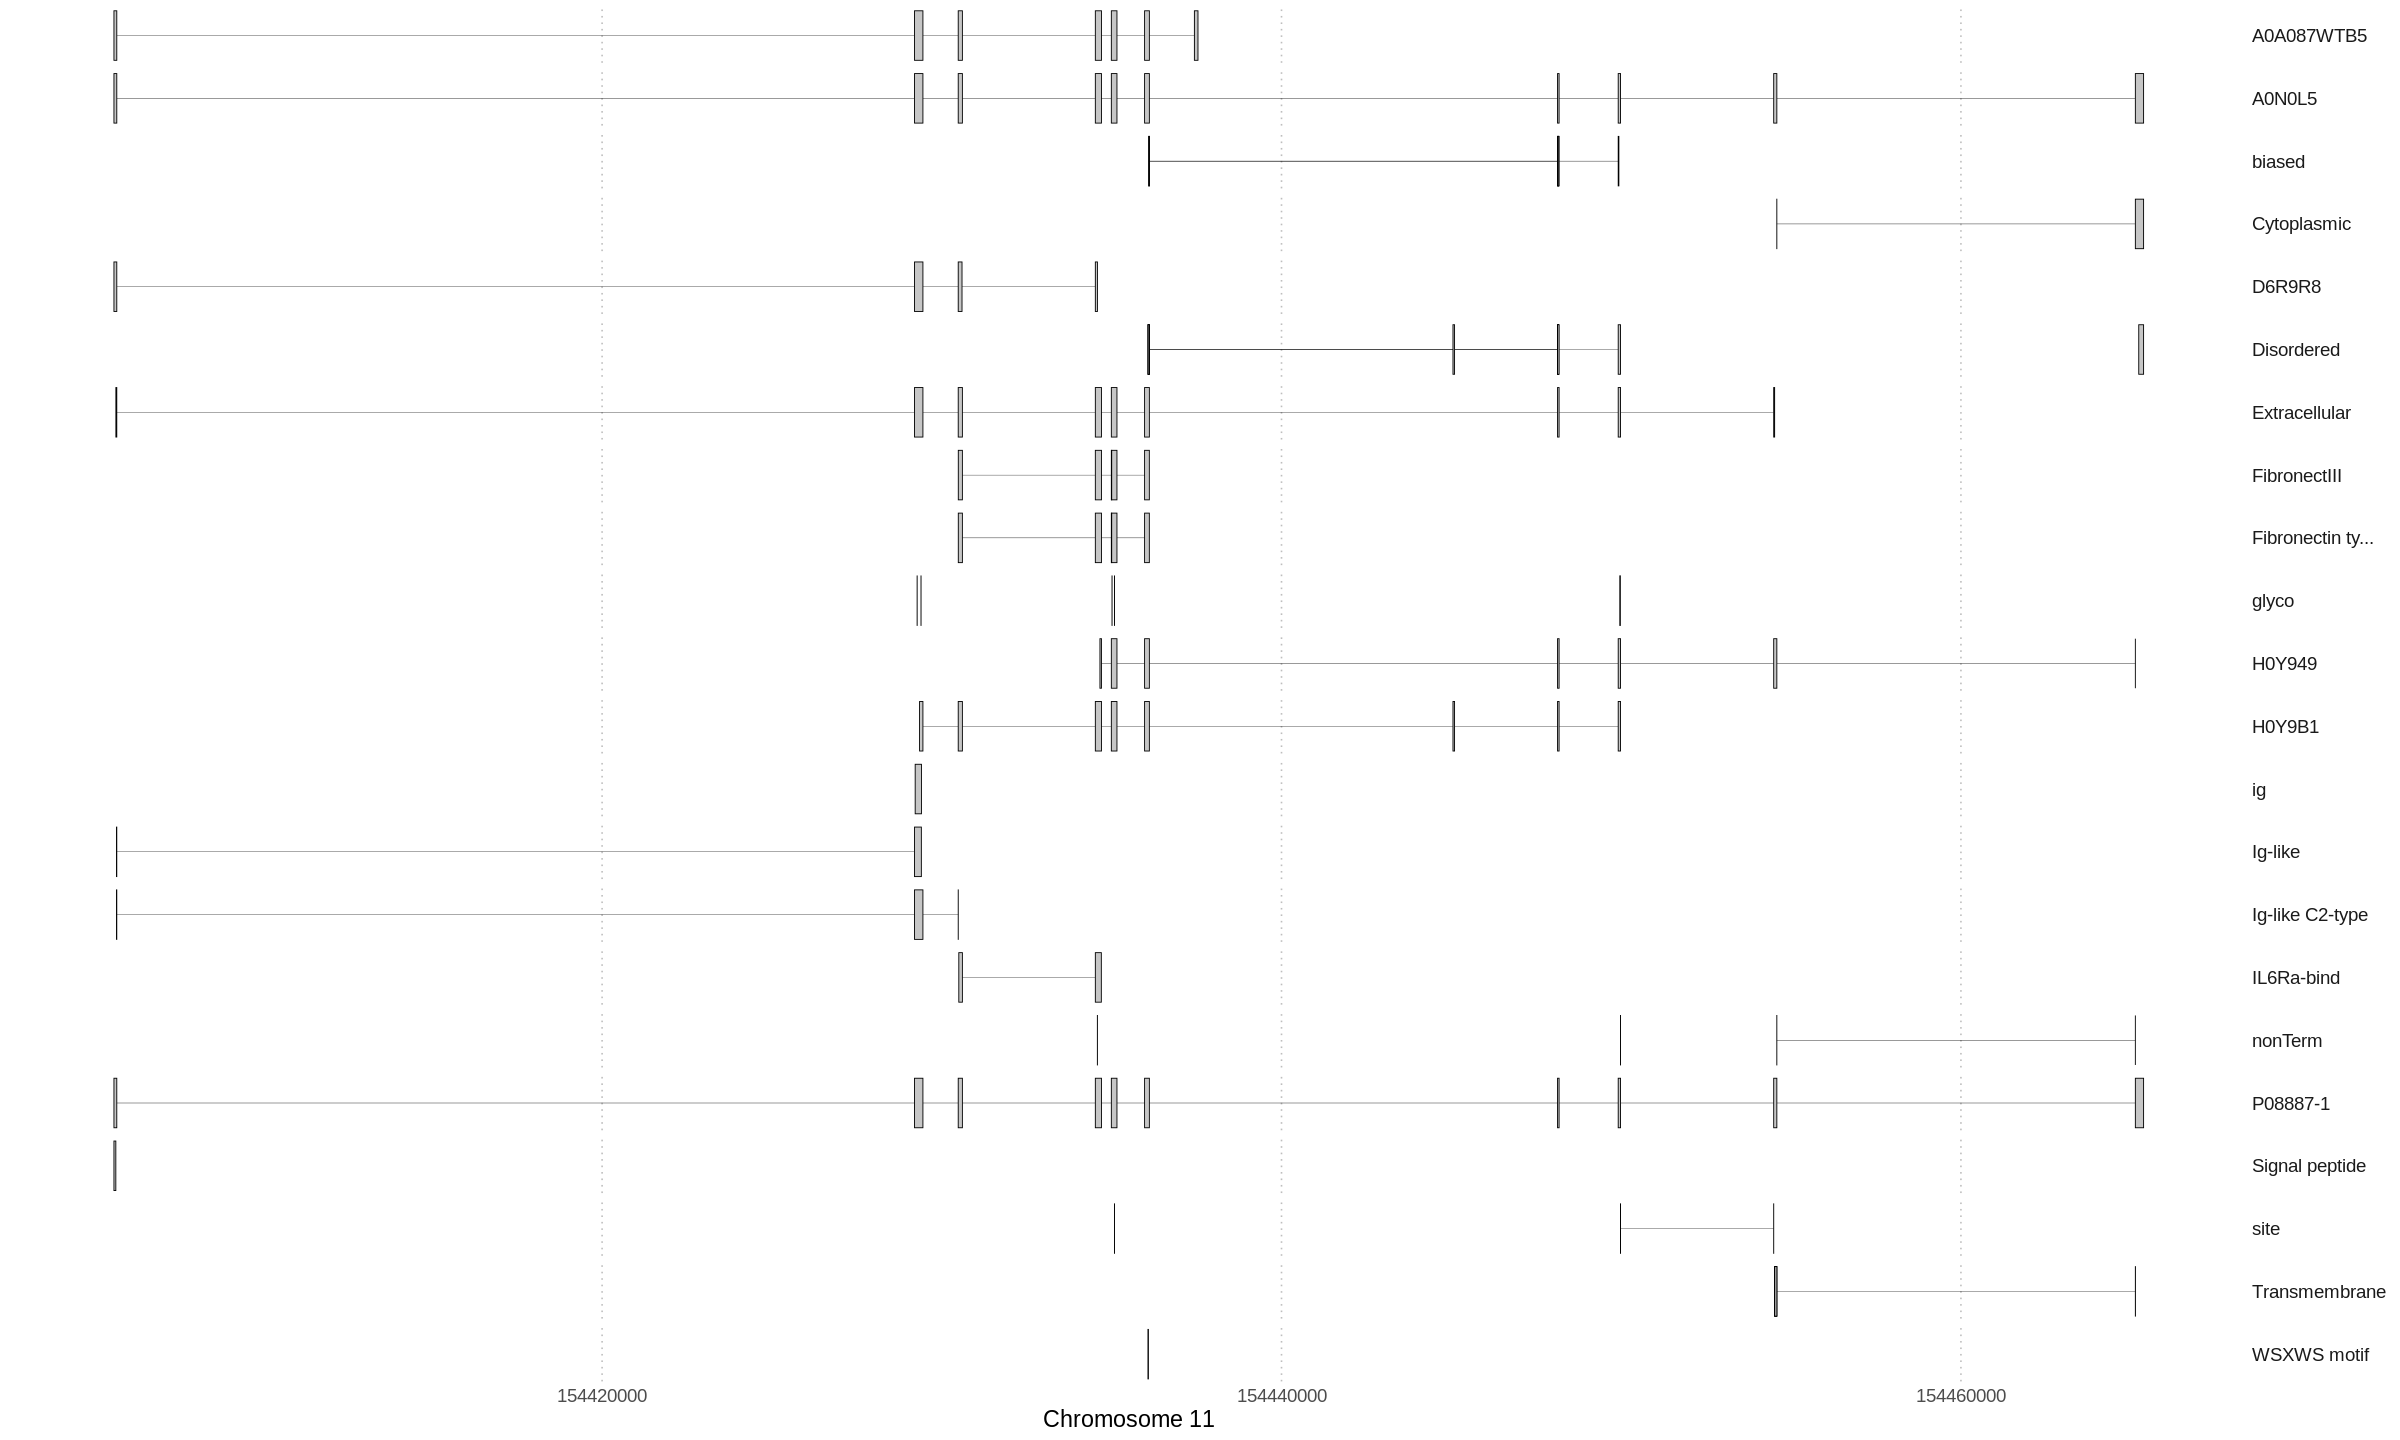

In [43]:
options(repr.plot.width=20, repr.plot.height=12)

domain_track_p <-
plot_tracks(
    # let's plot the protein domains we mapped to IL6R exons:
    il6r_domains_example_tb,
    # need to specify the strand (we know this is a + strand gene)
    # because this function always plots elements 5' to 3'
    #(+ strand genes will show increasing genomic coord left to right)
    #(- strand genes will show decreasing genomic coord left to right)
    strand = "+",
    # X axis label
    seqid = "Chromosome 11",
    # Use the jstart and jend columns to add splice-junctions between the same feature_unique_identifiers
    add_connections = T,
    # Each row corresponds to a distinct domain_name (can have distinct feature_unique_identifiers)
    facet_wrap_by = "domain_name",
    # width of the splice junctions
    intron_width=0.1
)  +
# ggplot2::facet_wrap(
#     ~domain_name,
#     ncol = 1,
#     strip.position = "right"
# ) +
theme(
    # increase font size of the facet labels
    text = element_text(size = 14),
    # make facet labels on left justified
    strip.text = element_text(hjust = 0),
    # remove background color from facet label boxes
    strip.background = element_rect(colour = "white",
                                    fill = "white"))

domain_track_p

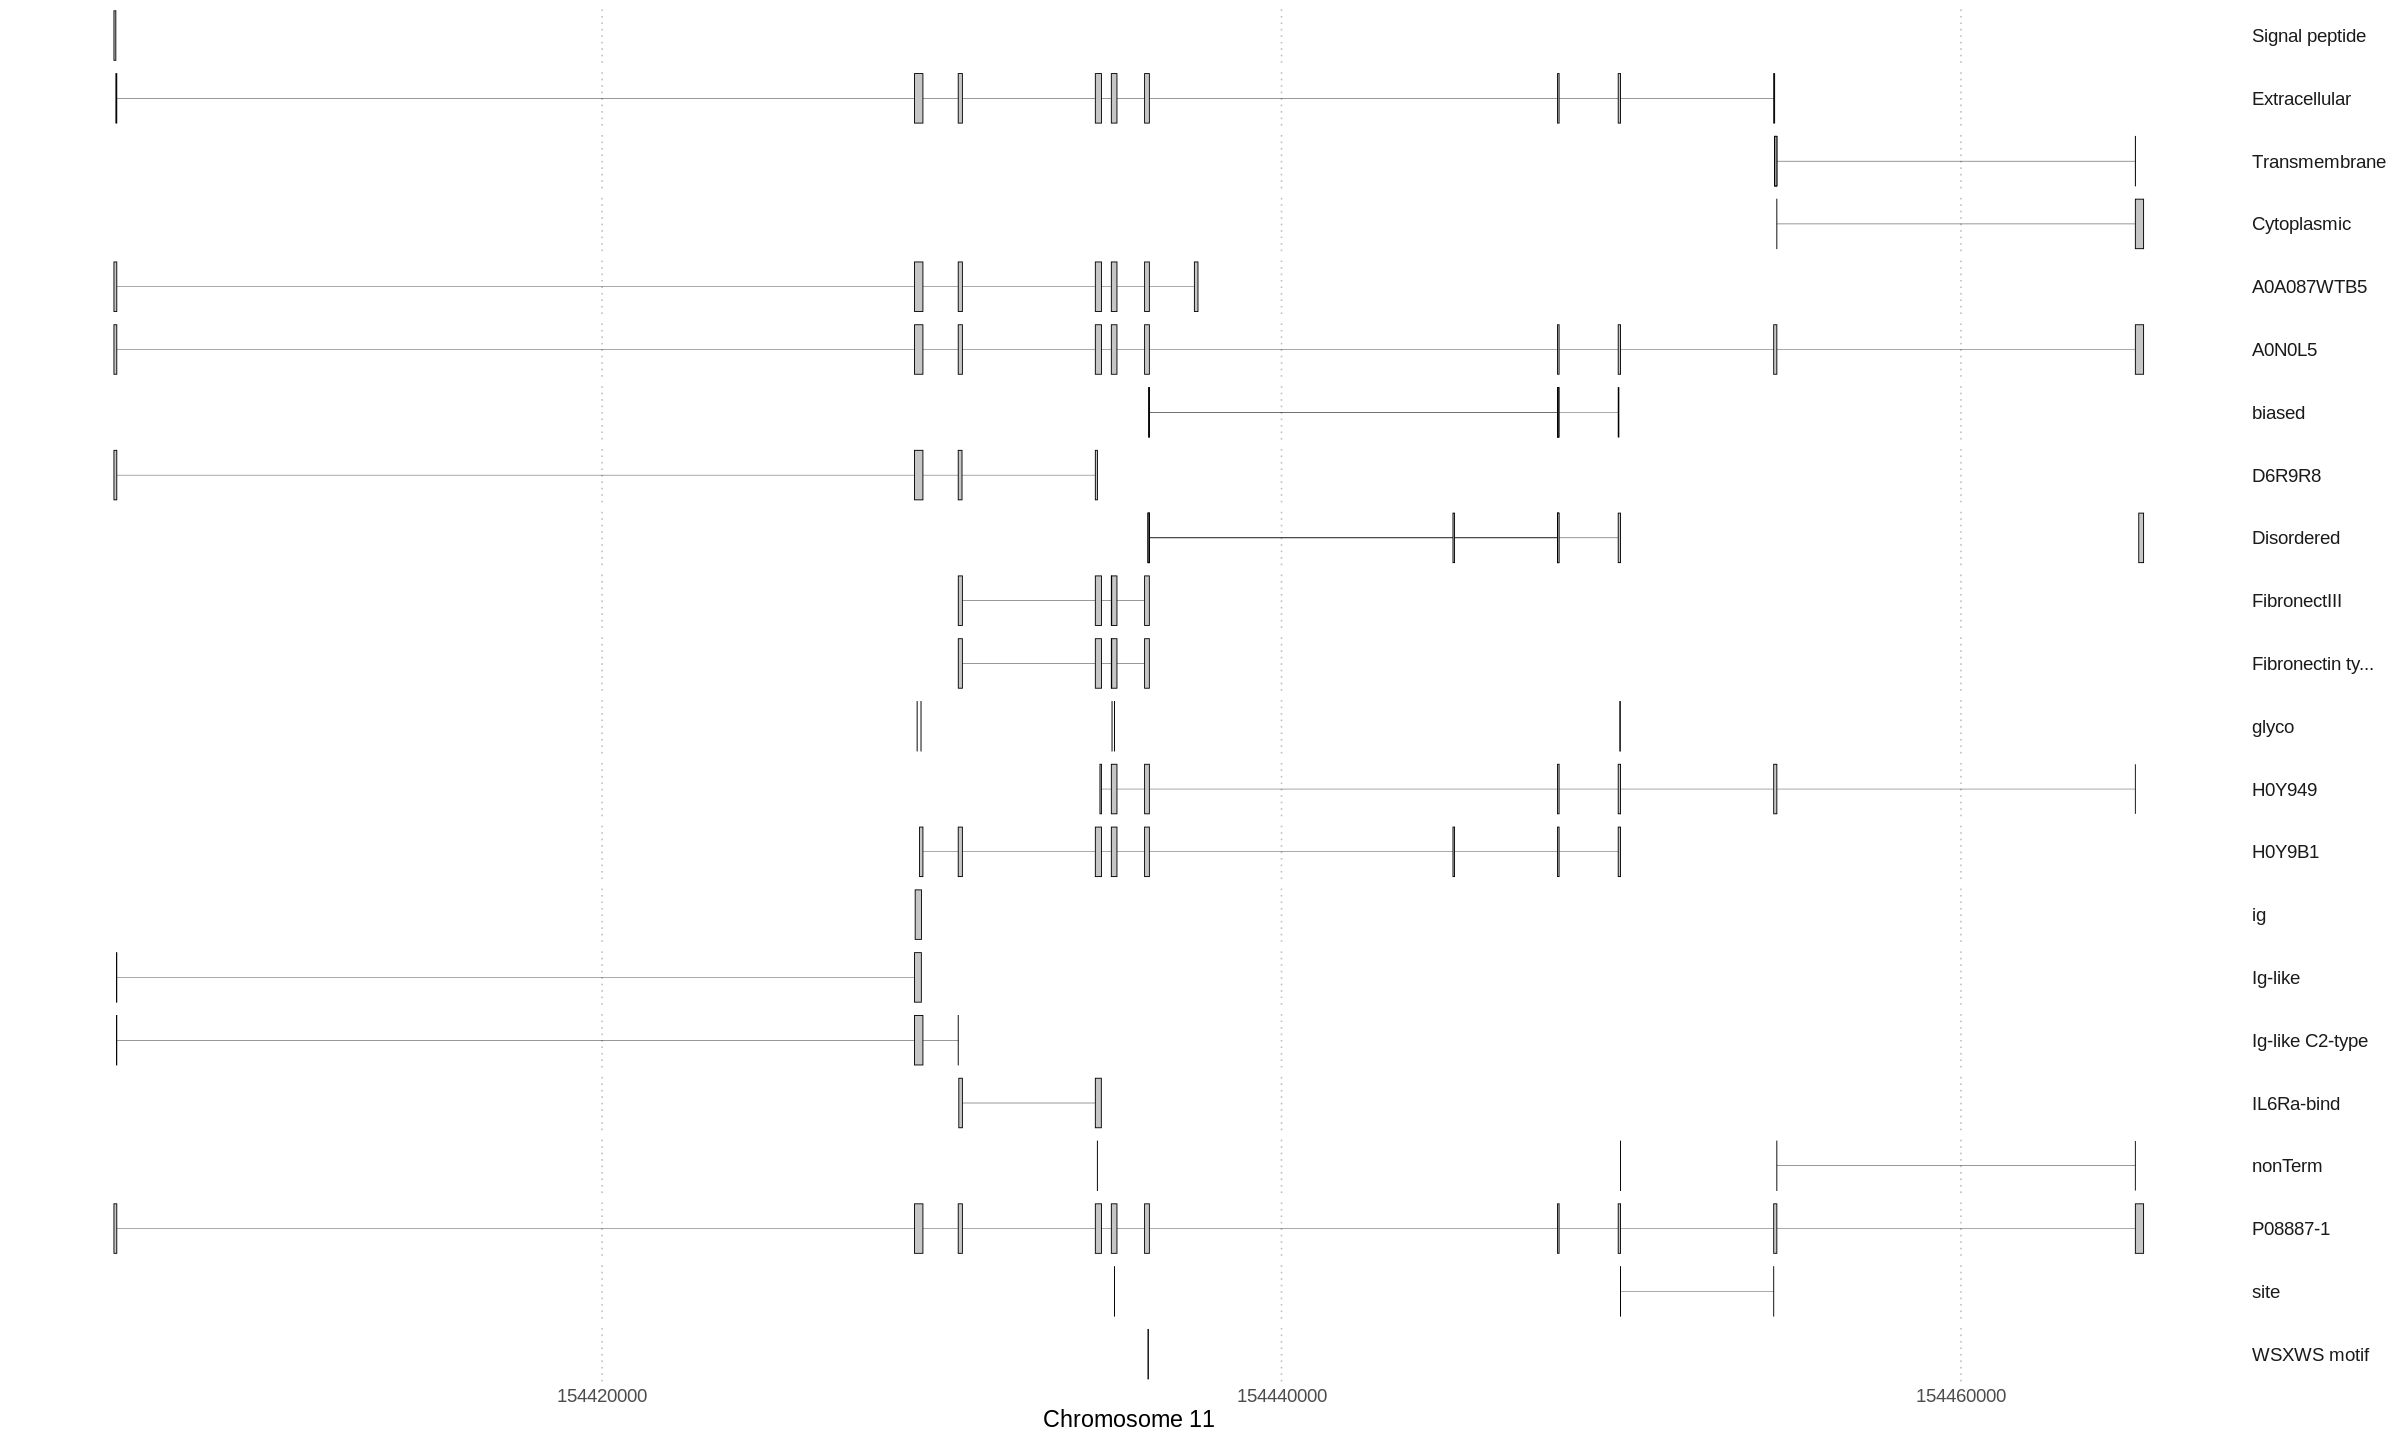

In [63]:
# Let's reorder the domains

domains_to_reorder <- sort(unique(il6r_domains_example_tb$domain_name))

# put these domains at the top, in this order
priority_tracks <- c(
        "enzyme act site",
        "Signal peptide",
        "Extracellular",
        "Transmembrane",
        "Cytoplasmic"
    )
priority_tracks_wehave <- priority_tracks[priority_tracks %in% domains_to_reorder]

il6r_domains_example_tb$domain_name <- factor(
    il6r_domains_example_tb$domain_name,
    levels = c(
        priority_tracks,
        # all the other domains will be alphabetical
        sort(setdiff(domains_to_reorder, priority_tracks))
    )
)

options(repr.plot.width=20, repr.plot.height=12)

domain_track_p <-
plot_tracks(
    il6r_domains_example_tb,
    strand = "+",
    seqid = "Chromosome 11",
    add_connections = T,
    facet_wrap_by = "domain_name",
    intron_width=0.1
)  +
theme(
    text = element_text(size = 14),
    strip.text = element_text(hjust = 0),
    strip.background = element_rect(colour = "white",
                                    fill = "white"))

# now we see the priority tracks at the top!
domain_track_p

In [139]:
il6r_transcripts_example_tb <-
transcripts %>%
    filter(gene_name == "IL6R") %>%
    select(feature, feature_start, feature_end, transcript_id, gene_name, strand, transcript_support_level, transcript_biotype) %>%
    arrange(feature_start) %>%
    # this function adds jstart and jend, the exon-exon junction coordinates beween each exon
    add_introns(exon_col_start = "feature_start", exon_col_end = "feature_end", groupby = "transcript_id") %>%
    dplyr::rename(tsl = transcript_support_level) %>%
    dplyr::mutate(
        tsl = paste0("tsl", tsl),
        simplified_biotype = ifelse(transcript_biotype == "protein_coding", "cod", transcript_biotype),
        simplified_biotype = ifelse(simplified_biotype == "nonsense_mediated_decay", "nmd", simplified_biotype),
        simplified_biotype = ifelse(simplified_biotype %in% c("cod", "nmd"), simplified_biotype, "oth"),
        transcript_label = factor(stringr::str_c(transcript_id, ",", tsl, ",", simplified_biotype))
    )

dim(il6r_transcripts_example_tb)
head(il6r_transcripts_example_tb %>% arrange(transcript_id, start), 12)

[1] 51 12

feature,start,end,transcript_id,gene_name,strand,tsl,transcript_biotype,jstart,jend,simplified_biotype,transcript_label
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>
exon,154405223,154405714,ENST00000344086,IL6R,+,tsl1,protein_coding,154405714,154429196,cod,"ENST00000344086,tsl1,cod"
exon,154429196,154429444,ENST00000344086,IL6R,+,tsl1,protein_coding,154429444,154430483,cod,"ENST00000344086,tsl1,cod"
exon,154430483,154430606,ENST00000344086,IL6R,+,tsl1,protein_coding,154430606,154434519,cod,"ENST00000344086,tsl1,cod"
exon,154434519,154434700,ENST00000344086,IL6R,+,tsl1,protein_coding,154434700,154434990,cod,"ENST00000344086,tsl1,cod"
exon,154434990,154435156,ENST00000344086,IL6R,+,tsl1,protein_coding,154435156,154435969,cod,"ENST00000344086,tsl1,cod"
exon,154435969,154436110,ENST00000344086,IL6R,+,tsl1,protein_coding,154436110,154448125,cod,"ENST00000344086,tsl1,cod"
exon,154448125,154448171,ENST00000344086,IL6R,+,tsl1,protein_coding,154448171,154449911,cod,"ENST00000344086,tsl1,cod"
exon,154449911,154449980,ENST00000344086,IL6R,+,tsl1,protein_coding,154449980,154465134,cod,"ENST00000344086,tsl1,cod"
exon,154465134,154466877,ENST00000344086,IL6R,+,tsl1,protein_coding,NA,NA,cod,"ENST00000344086,tsl1,cod"


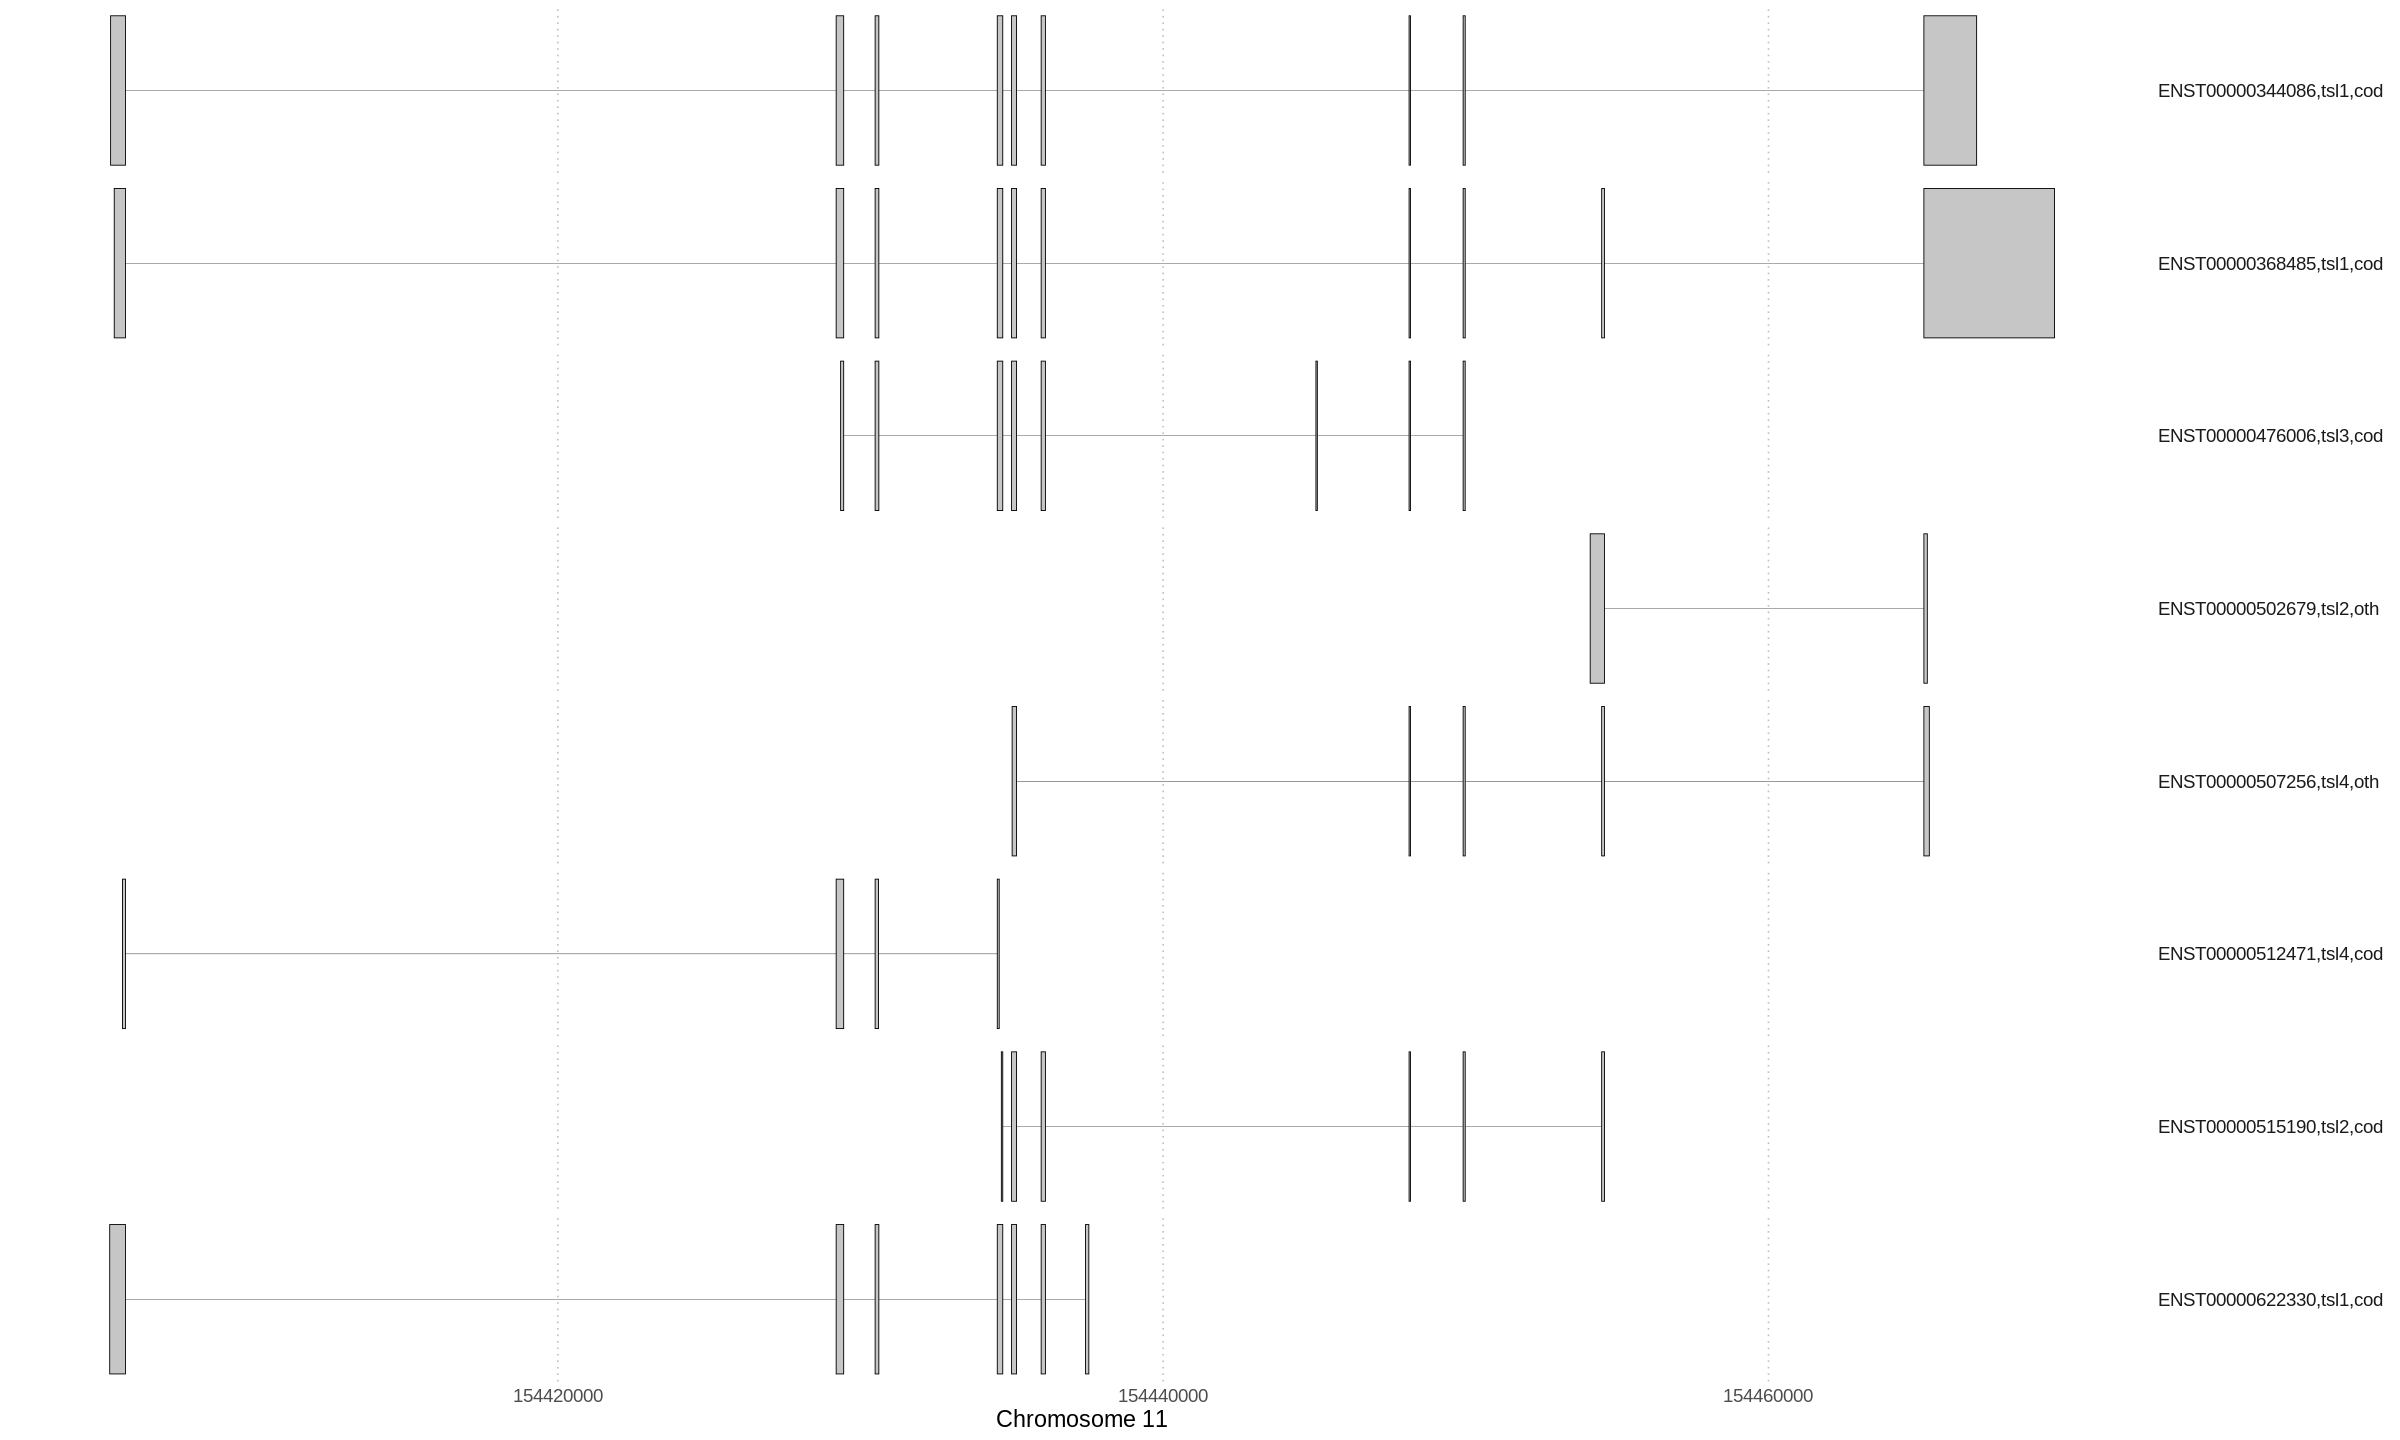

In [140]:
options(repr.plot.width=20, repr.plot.height=12)


preferred_tx_biotype_order <- c(
    "protein_coding",
    "nonsense_mediated_decay",
    "non_stop_decay",
    "antisense",
    "retained_intron",
    "ribozyme",
    "non_coding",
    "sense_intronic",
    "sense_overlapping",
    "TEC",
    "rRNA_pseudogene",
    "miRNA",
    "rRNA",
    "vaultRNA",
    "misc_RNA",
    "antisense_RNA",
    "sRNA",
    "scRNA",
    "macro_lncRNA",
    "bidirectional_promoter_lncRNA",
    "bidirectional_promoter_lncrna",
    "snoRNA",
    "snRNA",
    "scaRNA",
    "3prime_overlapping_ncRNA",
    "vault_RNA",
    "lincRNA",
    "3prime_overlapping_ncrna",
    "Mt_rRNA",
    "Mt_tRNA",
    "lncRNA",
    "IG_D_gene",
    "IG_J_gene",
    "IG_C_gene",
    "IG_V_gene",
    "IG_V_pseudogene",
    "IG_C_pseudogene",
    "IG_J_pseudogene",
    "IG_pseudogene",
    "TR_J_gene",
    "TR_D_gene",
    "TR_V_gene",
    "TR_J_pseudogene",
    "TR_C_gene",
    "TR_V_pseudogene",
    "processed_transcript",
    "pseudogene",
    "transcribed_unitary_pseudogene",
    "transcribed_unprocessed_pseudogene",
    "polymorphic_pseudogene",
    "unitary_pseudogene",
    "translated_processed_pseudogene",
    "unprocessed_pseudogene",
    "transcribed_processed_pseudogene",
    "processed_pseudogene",
    "translated_unprocessed_pseudogene"
)



# Let's plot the transcripts plot, with some extra info
transcript_p <-
plot_tracks(
    il6r_transcripts_example_tb,
    strand = "+",
    seqid = "Chromosome 11",
    add_connections = T,
    facet_wrap_by = "transcript_label",
    intron_width=0.1
)  +
theme(
    text = element_text(size = 14),
    strip.text = element_text(hjust = 0),
    strip.background = element_rect(colour = "white",
                                    fill = "white"))

transcript_p

In [141]:
head(il6r_domains_example_tb, 3) %>%
    rename(feature_name = domain_name) %>%
    select(feature_name, start, end, strand, jstart, jend)

feature_name,start,end,strand,jstart,jend
<fct>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
Signal peptide,154405630,154405686,+,NA,NA
D6R9R8,154405630,154405714,+,154405714,154429195
A0A087WTB5,154405630,154405714,+,154405714,154429195


In [142]:
head(il6r_transcripts_example_tb, 3) %>%
    rename(feature_name = transcript_label) %>%
    select(feature_name, start, end, strand, jstart, jend)

feature_name,start,end,strand,jstart,jend
<fct>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
"ENST00000344086,tsl1,cod",154405223,154405714,+,154405714,154429196
"ENST00000344086,tsl1,cod",154429196,154429444,+,154429444,154430483
"ENST00000344086,tsl1,cod",154430483,154430606,+,154430606,154434519


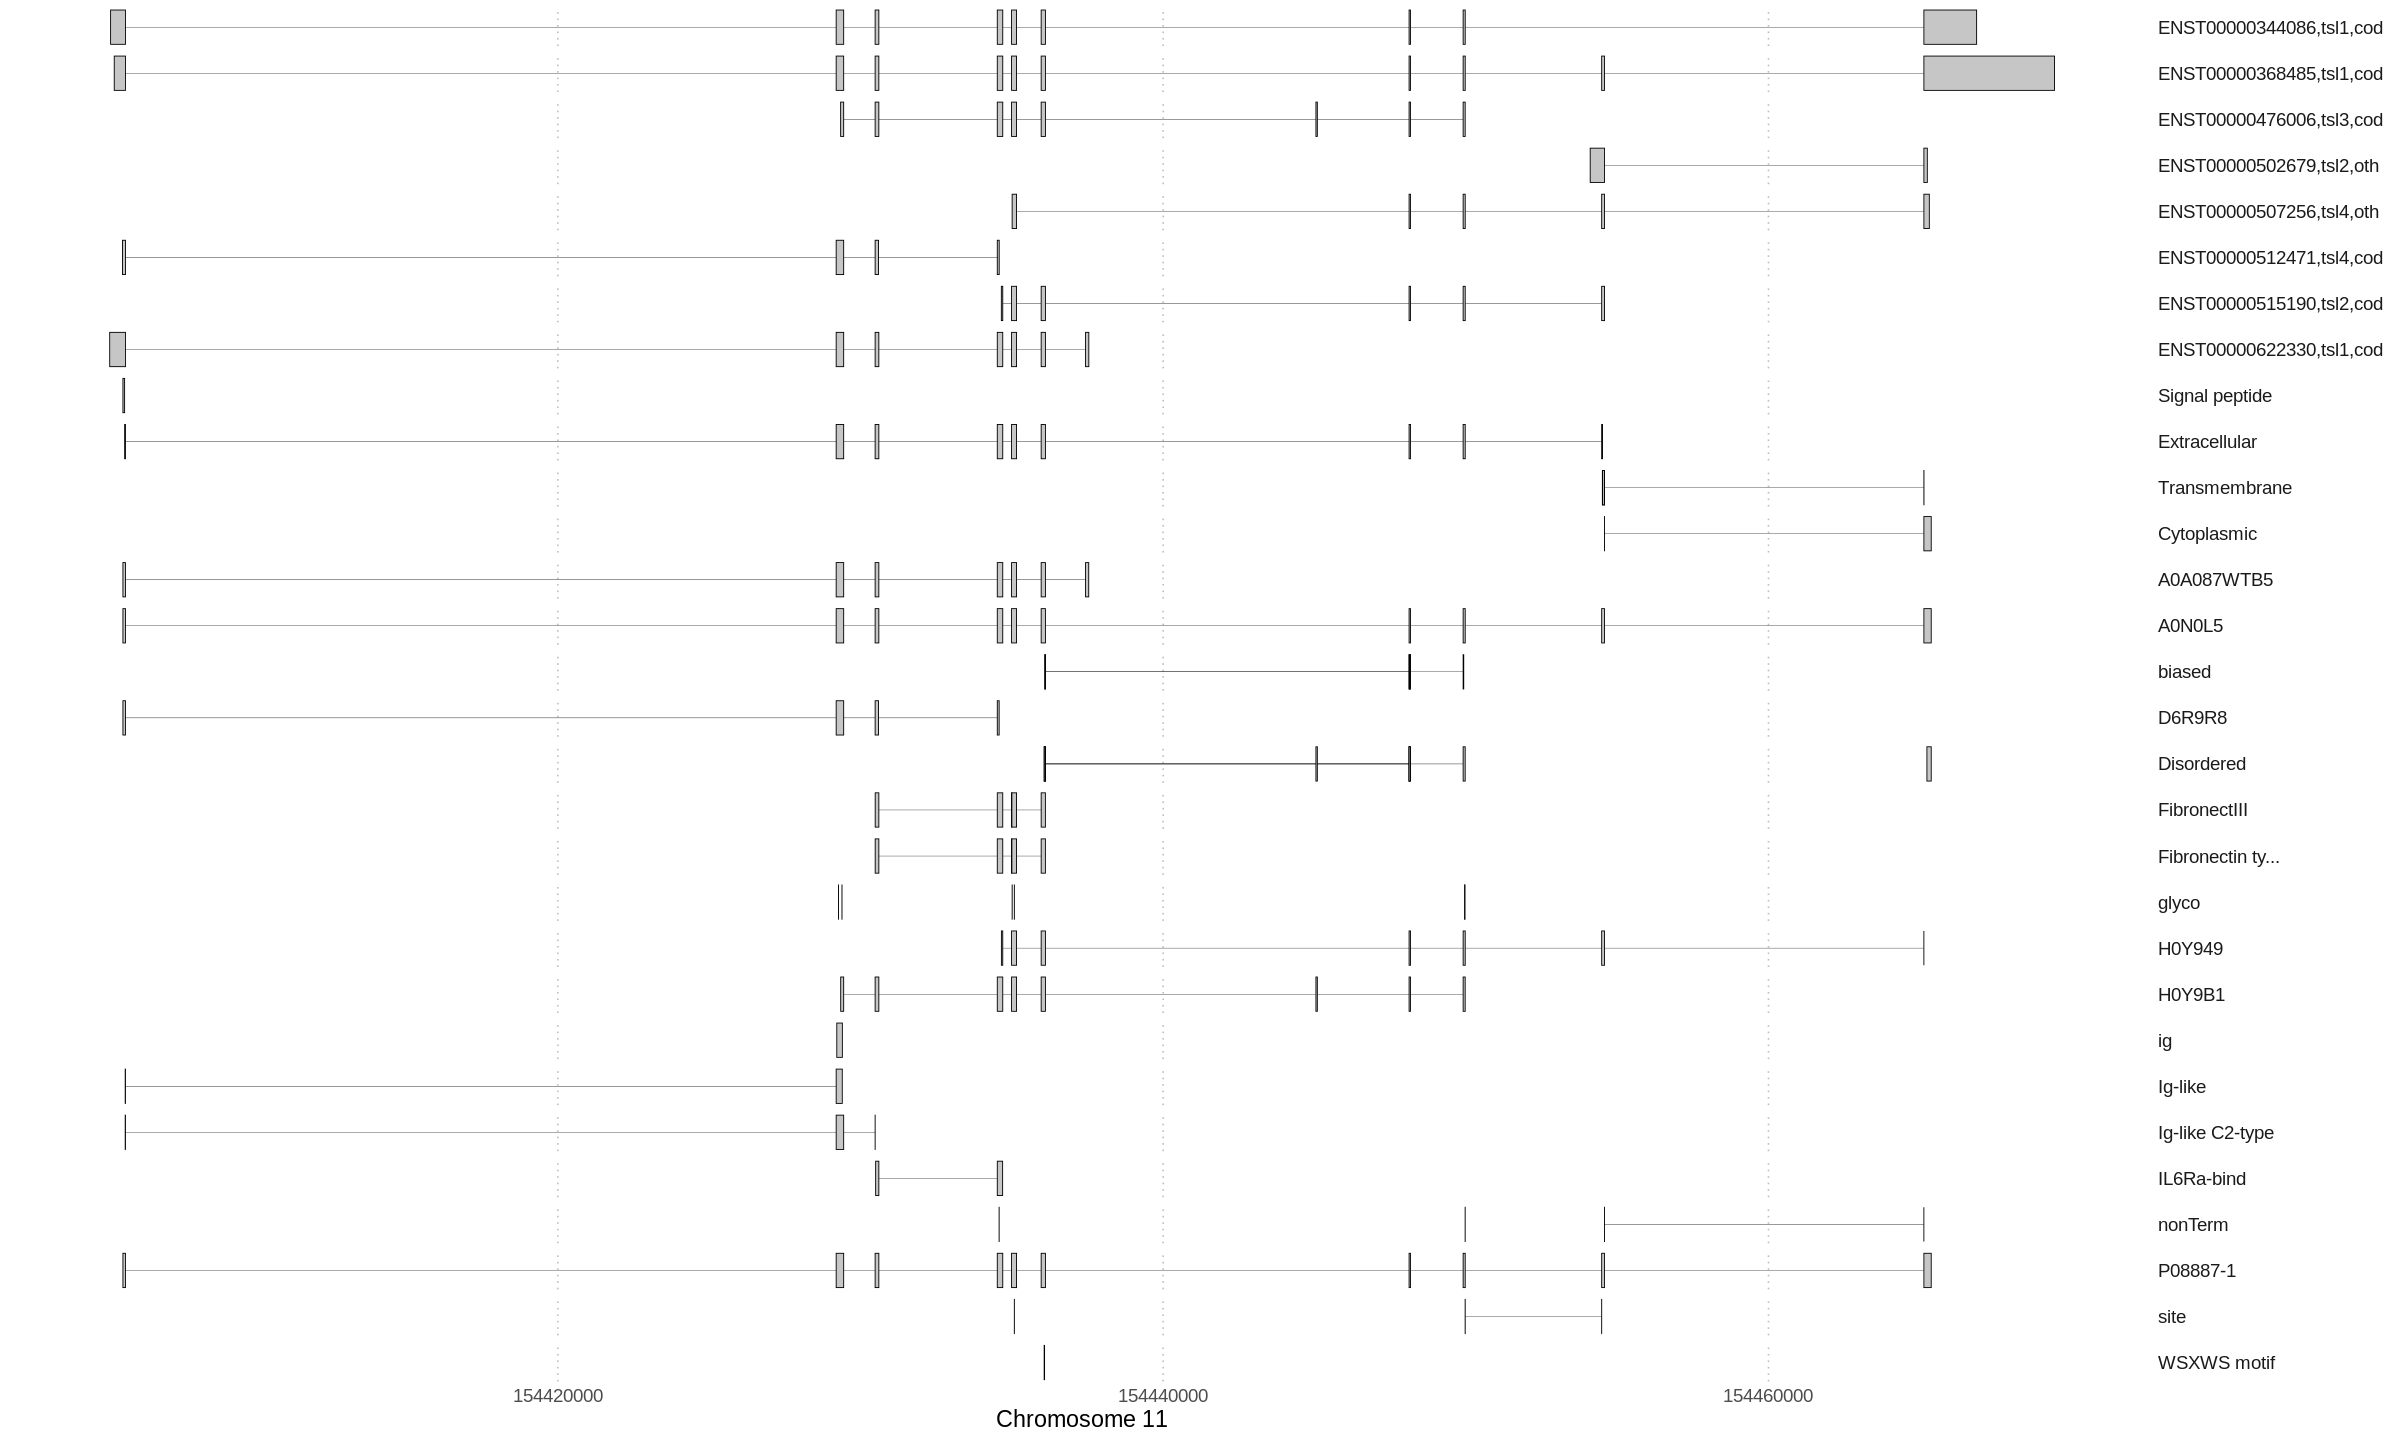

In [172]:
# Now, let's plot everything together!

transcript_domain_tb <-
bind_rows(
    il6r_transcripts_example_tb %>%
        mutate(track_type = "Transcripts") %>%
        rename(feature_name = transcript_label) %>%
        select(feature_name, start, end, strand, jstart, jend, track_type),
    il6r_domains_example_tb %>%
        mutate(track_type = "Domains") %>%
        rename(feature_name = domain_name) %>%
        select(feature_name, start, end, strand, jstart, jend, track_type)
) %>%
# Order transcripts on top, then domains
mutate(track_type = factor(track_type, levels = c("Transcripts", "Domains")))

transcript_domain_tb %>% 
plot_tracks(
    .,
    strand = "+",
    seqid = "Chromosome 11",
    add_connections = T,
    facet_wrap_by = "feature_name",
    intron_width=0.1
)  +
theme(
    text = element_text(size = 14),
    strip.text = element_text(hjust = 0),
    strip.background = element_rect(colour = "white",
                                    fill = "white"))


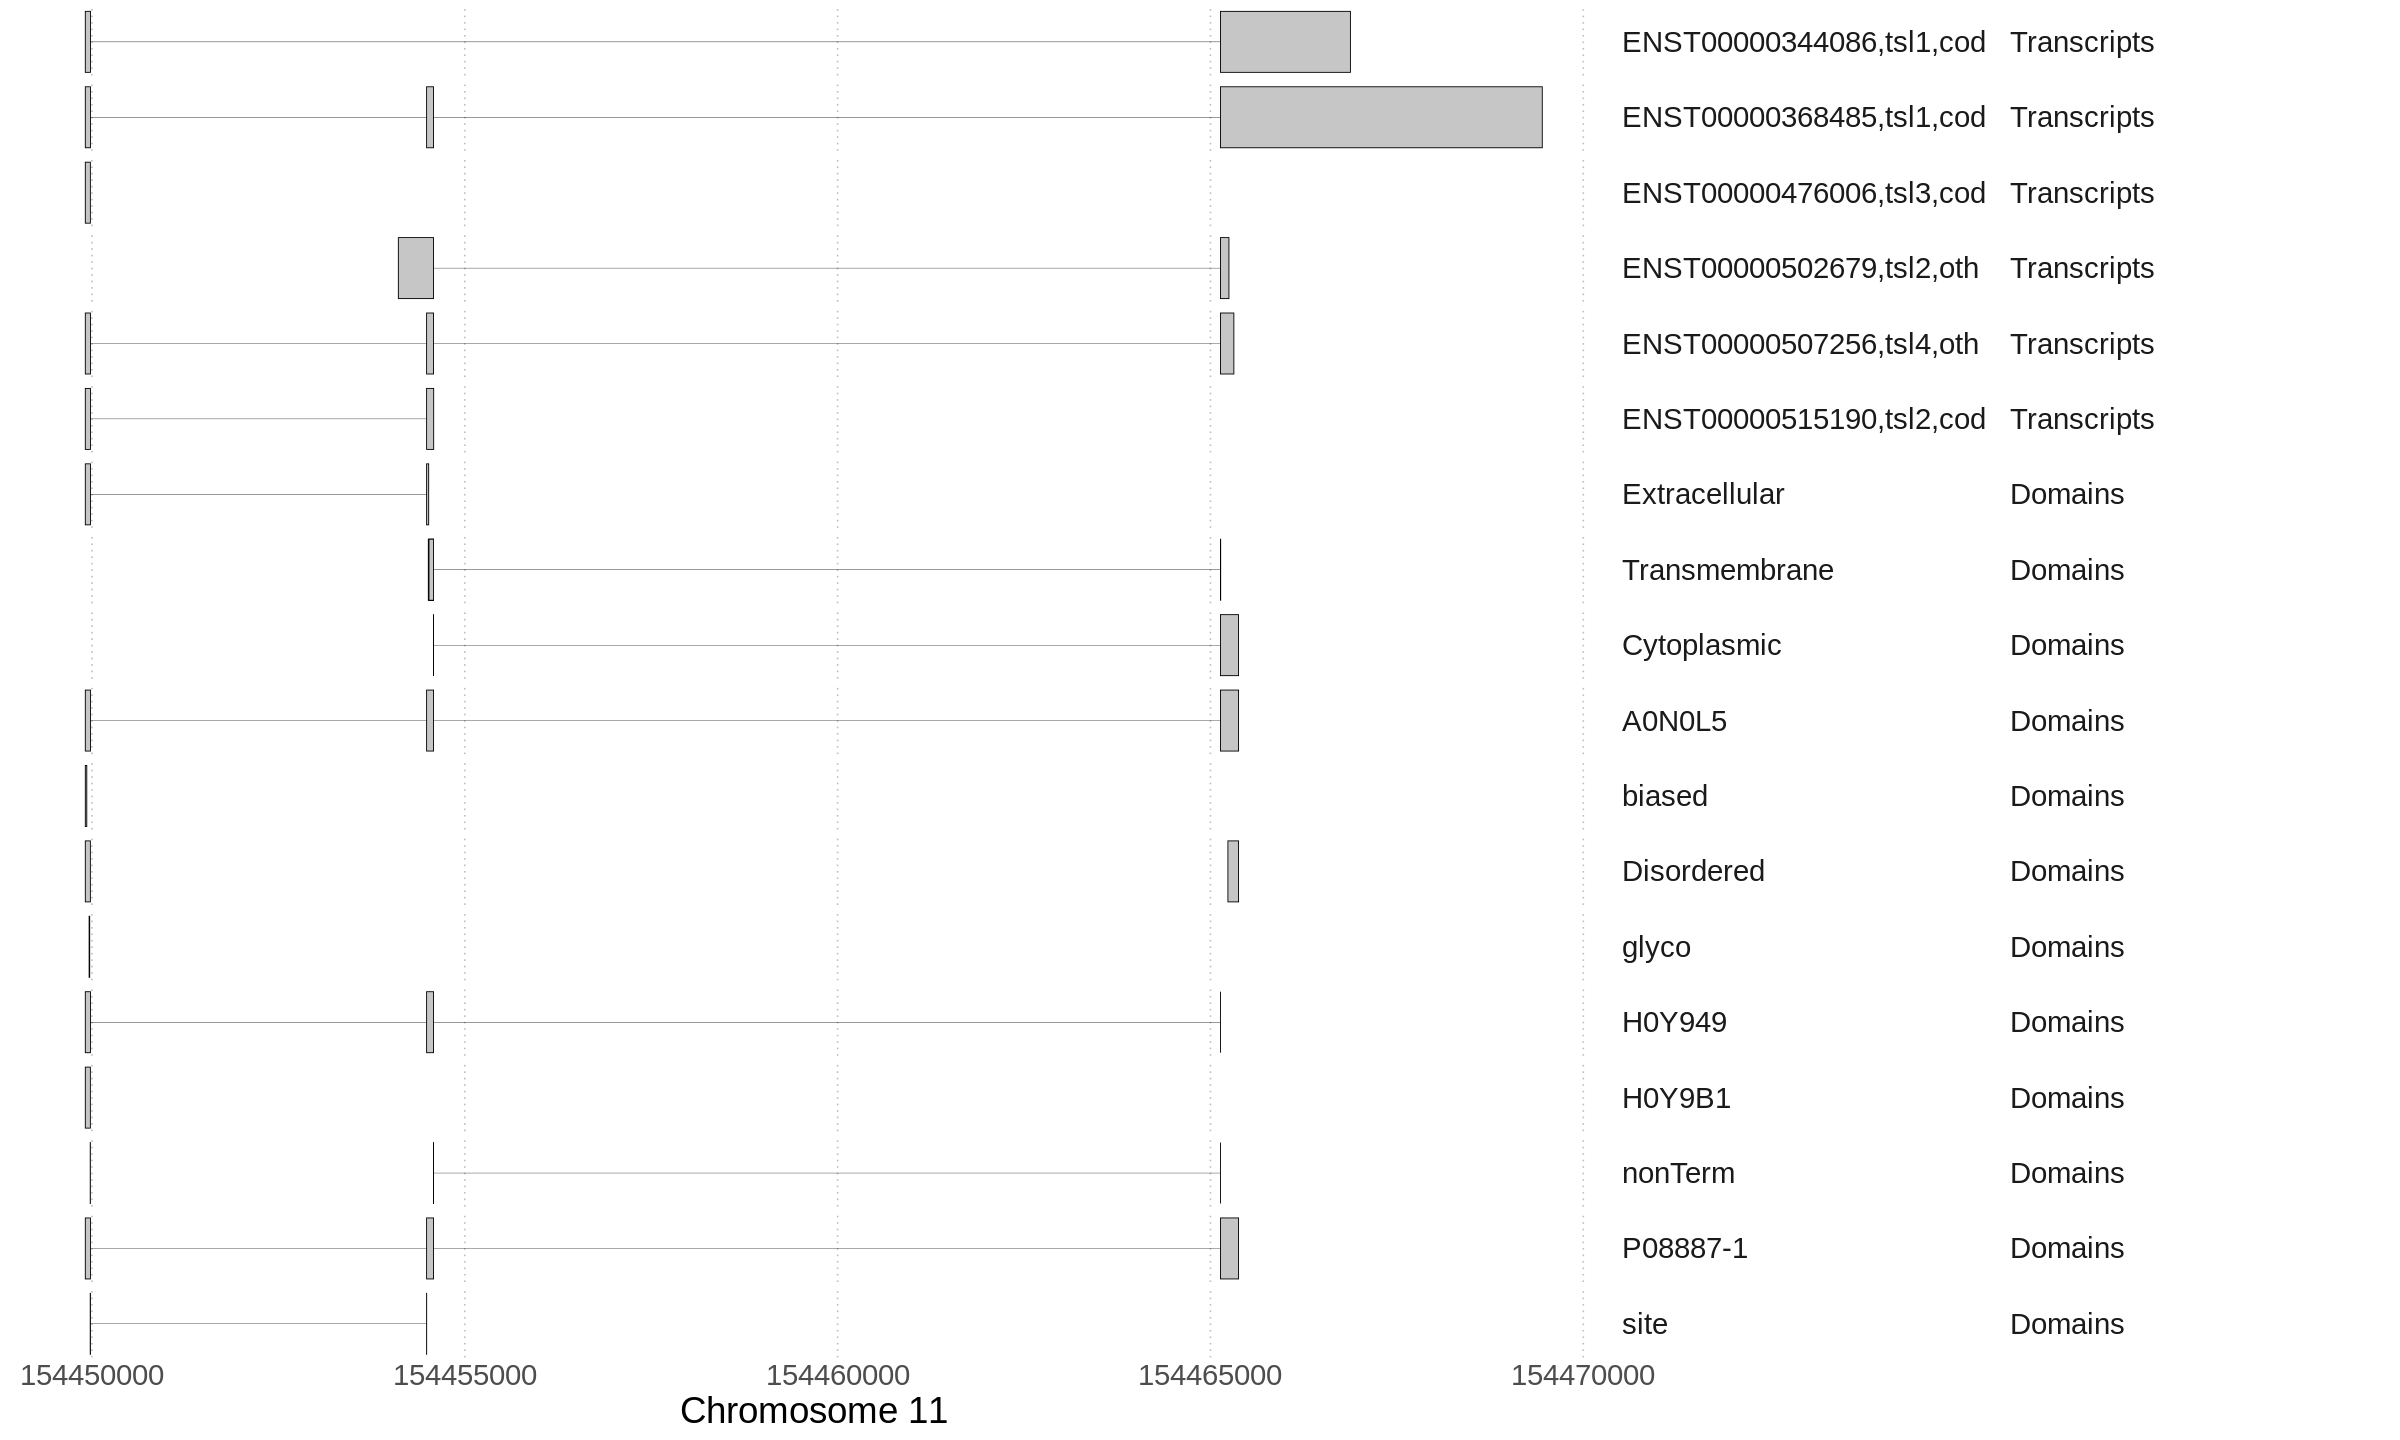

In [175]:
options(repr.plot.width=20, repr.plot.height=12)


# zoom in
transcript_domain_tb %>% 
filter(start >= 154449000 & end <= 154470000) %>%

plot_tracks(
    .,
    strand = "+",
    seqid = "Chromosome 11",
    add_connections = T,
    facet_wrap_by = "feature_name",
    intron_width=0.1
)  +
# Add the track_type
ggplot2::facet_wrap(
                track_type ~ feature_name,
                ncol = 1,
                strip.position = "right"
            ) +
theme(
    text = element_text(size = 22),
    strip.text = element_text(hjust = 0),
    strip.background = element_rect(colour = "white",
                                    fill = "white"))
